
--- Model Performance ---
✅ R² Score: 0.31
📉 RMSE: 1.13


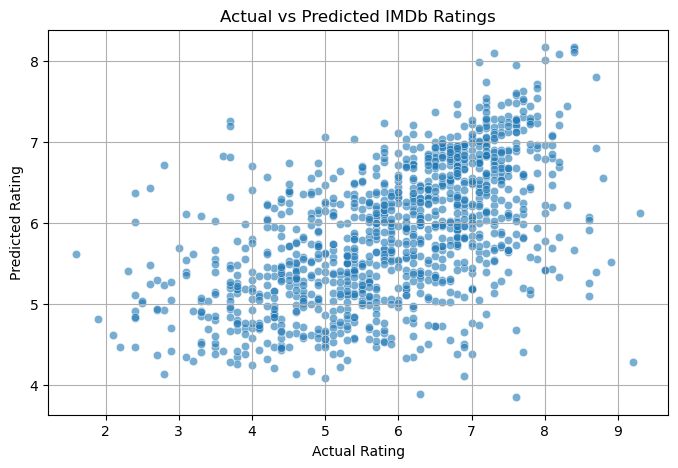


--- Feature Importances ---
votes       0.219445
year        0.209337
genre       0.138200
duration    0.101131
actor1      0.089038
actor2      0.083377
actor3      0.082111
director    0.077360
dtype: float64


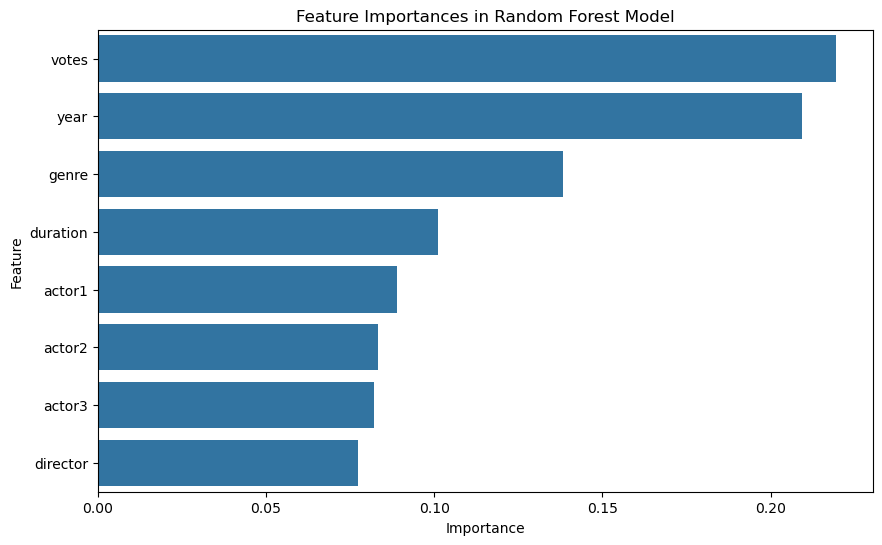

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Import numpy for sqrt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score

# 📂 Load the dataset with correct encoding
try:
    df = pd.read_csv("IMDb Movies India.csv", encoding='latin1')
except FileNotFoundError:
    print("Error: 'IMDb Movies India.csv' not found. Please ensure the file is in the correct directory.")
    exit() # Exit if the file is not found

# 🧱 Use correct column names from the dataset and handle potential missing columns gracefully
required_columns = ['Name', 'Year', 'Duration', 'Genre', 'Rating', 'Votes', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']
if not all(col in df.columns for col in required_columns):
    print("Error: One or more required columns are missing from the dataset.")
    print(f"Expected columns: {required_columns}")
    print(f"Available columns: {df.columns.tolist()}")
    exit()

df = df[required_columns].copy() # Use .copy() to avoid SettingWithCopyWarning

# 🏷️ Rename columns to simpler names (already good, just including for completeness)
df.columns = ['title', 'year', 'duration', 'genre', 'rating', 'votes', 'director', 'actor1', 'actor2', 'actor3']

# 🧹 Clean the 'year' column: extract 4-digit year and convert to int
# Handle potential non-string values before string operations
df['year'] = df['year'].astype(str).str.extract(r'(\d{4})')[0] # [0] to get the series from the DataFrame
df.dropna(subset=['year'], inplace=True)
df['year'] = df['year'].astype(int)

# 🧹 Clean the 'duration' column: extract numeric duration and convert to int
# Convert to string first to handle potential non-string types, then extract digits
df['duration'] = df['duration'].astype(str).str.extract(r'(\d+)').astype(float)
df.dropna(subset=['duration'], inplace=True)
df['duration'] = df['duration'].astype(int)


# 🧹 Clean the 'votes' column: remove commas and convert to int
# Ensure 'votes' is treated as string before replacement, then convert to numeric
df['votes'] = df['votes'].astype(str).str.replace(',', '', regex=False)
# Convert to numeric, coercing errors to NaN, then fillna(0) or dropna
df['votes'] = pd.to_numeric(df['votes'], errors='coerce')
df.dropna(subset=['votes'], inplace=True)
df['votes'] = df['votes'].astype(int)


# 🧼 Drop any remaining rows with missing values (including those introduced by cleaning)
df.dropna(inplace=True)

# 🔠 Convert categorical text columns to numeric using Label Encoding
le = LabelEncoder()
categorical_cols = ['genre', 'director', 'actor1', 'actor2', 'actor3']
for col in categorical_cols:
    if col in df.columns: # Ensure column exists before encoding
        df[col] = le.fit_transform(df[col])
    else:
        print(f"Warning: Categorical column '{col}' not found for encoding.")

# 🎯 Features (X) and Target (y)
# Ensure all features exist before defining X
features = ['genre', 'director', 'actor1', 'actor2', 'actor3', 'year', 'duration', 'votes']
X = df[features]
y = df['rating']

# 🪓 Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🌲 Train the Random Forest Model
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1) # n_jobs=-1 for parallel processing
model.fit(X_train, y_train)

# 📊 Predict on the test set
y_pred = model.predict(X_test)

# 📈 Evaluate model performance
r2 = r2_score(y_test, y_pred)
# --- FIX STARTS HERE ---
mse = mean_squared_error(y_test, y_pred) # Calculate Mean Squared Error first
rmse = np.sqrt(mse) # Then take the square root for RMSE
# --- FIX ENDS HERE ---

print("\n--- Model Performance ---")
print("✅ R² Score:", round(r2, 2))
print("📉 RMSE:", round(rmse, 2))

# 🎨 Visualize Actual vs Predicted Ratings
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.title("Actual vs Predicted IMDb Ratings")
plt.grid(True)
plt.show()

# Optional: Display feature importances
print("\n--- Feature Importances ---")
feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_importances)

# Optional: Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title("Feature Importances in Random Forest Model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()
